In [7]:
import networkx as nx

from randomgen import RandomGenerator, PCG64

import constants
from experimental_design import load_design_file, get_trial_settings
from randomness import REPLICATION_ISEED_STREAM_ARRAY
from randomness import RNGStream, RandomGenRandomInterface

import networks
import numpy as np


In [8]:
design = load_design_file()  # need these to build edge list

rep = 1  # arbitrary

In [9]:
# these trials cover each network model at N = 100
trial_nums = np.array([1, 4, 7, 10, 13, 16, 19, 22, 25, 28]) + 0  # +1 to get to N = 1000

In [21]:
degree_distros = []
network_instances = []

for trial_num in trial_nums:
    trial_settings = get_trial_settings(trial_num, design)
    network_parameters = trial_settings['network_parameters']
    rg = RandomGenerator(PCG64(REPLICATION_ISEED_STREAM_ARRAY[rep], RNGStream.GRAPH_GENERATOR + 1))
    network_rg = RandomGenRandomInterface(rg)
    G = getattr(networks, network_parameters[0])(*network_parameters[1], network_rg)
    G = networks.prepare_graph_for_trial(G, network_rg)  # make directed, connected, & free of self-loops

#     nx.write_graphml(G, f'{network_parameters[0]}_{"_".join([str(x) for x in network_parameters[1]])}.graphml')
    network_instances.append(G)

In [ ]:
...

go make images in Cytoscape

In [ ]:
...

In [10]:
network_structure_model = [
        'erdos_renyi_random(N)',
        'small_world(N, 0.0, 3)',
        'small_world(N, 0.0, 10)',
        'small_world(N, 0.33, 3)',
        'small_world(N, 0.33, 10)',
        'small_world(N, 0.66, 3)',
        'small_world(N, 0.66, 10)',
        'scale_free(N, 1)',
        'scale_free(N, 3)',
        'scale_free(N, 5)',
    ]

In [5]:

import matplotlib.pyplot as plt
from my_plot import set_size, setup_mpl_for_latex
setup_mpl_for_latex()

textwidth = 390  ###

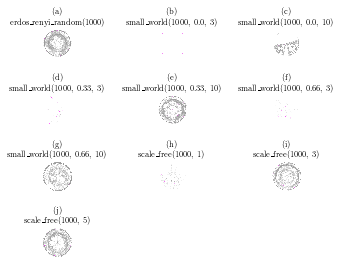

In [19]:
import string

from PIL import Image

nrows, ncols = 4, 3
fig, axes = plt.subplots(nrows, ncols, figsize=set_size(textwidth, subplot=[nrows, ncols], fraction=0.9))

for i, ax in enumerate(axes.ravel()):
    try:
        network_name = network_structure_model[i].replace('N', '1000')
    except IndexError:
        break  # axes.size > len(network_structure_model)
        
    img = Image.open(f'../images/{network_name}.png')
    ax.imshow(img, interpolation="none")

    ax.set_title(f'({string.ascii_lowercase[i]})\n{network_name}'.replace('_', '\_'), size=8)
    
    for edge, spine in ax.spines.items():
        spine.set_visible(False)
    
    ax.set_xticks([])
    ax.set_yticks([])
#     break
                   
axes.ravel()[-1].axis('off')        
axes.ravel()[-2].axis('off')        
                       
fig.tight_layout()


In [20]:
fig.savefig('../images/network_mosaic_N_1000.pdf', format='pdf', bbox_inches='tight')

make degree distribution plots

In [31]:
from scipy.stats import gaussian_kde
import string

def make_degree_kde(G, ax):
    data = np.array([G.out_degree(n) for n in G.nodes()])

    density = gaussian_kde(data)
    xs = np.linspace(data.min(), data.max(), 200)
    
    density.covariance_factor = lambda : .15
    density._compute_covariance()
    density_xs = density(xs)

    ax.plot(xs, density_xs, marker='', linewidth=0.5)
    
    ax.get_yaxis().set_visible(False)
    ax.spines['bottom'].set_color('grey')
    ax.spines['left'].set_color('None')
    ax.tick_params(axis='x', colors='grey')
    
    network_name = str(G).replace('N', '100').replace('_', '\_')
    ax.set_title(f'({string.ascii_lowercase[i]})\n{network_name}', size=8)


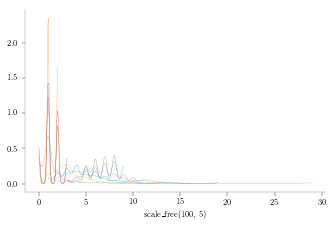

In [34]:

fig1, ax1 = plt.subplots(1, 1, figsize=set_size(textwidth))

for G in network_instances:
    make_degree_kde(G, ax1)

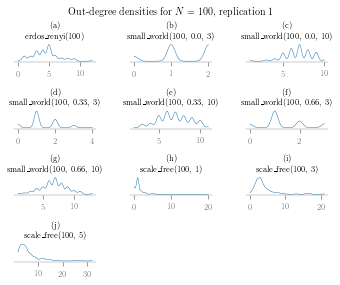

In [33]:
nrows, ncols = 4, 3
fig, axes = plt.subplots(nrows, ncols, figsize=set_size(textwidth, subplot=[nrows, ncols], fraction=0.9))

for i, ax in enumerate(axes.ravel()):
    try:
        make_degree_kde(network_instances[i], ax)
    except IndexError:
        break  # axes.size > len(network_structure_model)
        
fig.suptitle(f'Out-degree densities for $N = 100$, replication 1', size=10);

                   
axes.ravel()[-1].axis('off')        
axes.ravel()[-2].axis('off')        

fig.tight_layout()
fig.subplots_adjust(top=0.850)

In [34]:
fig.savefig('../images/network_degree_dist_N_100.pdf', format='pdf', bbox_inches='tight')

In [159]:

# remove label overlap

# other resources
# https://stackoverflow.com/questions/8850142/matplotlib-overlapping-annotations
# https://matplotlib.org/users/transforms_tutorial.html

def fix_vertical_text_placement(labels, fig, ax, maxy):
    # modified from
    # https://medium.com/@adarshlilha/removing-label-overlapping-from-pretty-charts-8dd2e3581b71
    
    # pixel coordinates
    extents = [lab.get_window_extent(renderer=fig.canvas.get_renderer()) for lab in labels]
    anchors = [0.5*(extent.y0 + extent.y1) for extent in extents]  # vert.align centers

    cur_y_vals = anchors.copy()

    half_height = labels[0].get_size() / 2

    # S.A. params
    weight_overlap = 100
    weight_dist = 2
    max_move = half_height
    
    min_y = 0
    max_y = ax.transData.transform((0, maxy))[1]  #maxy given in data coords
    
    def energy(index):
        ener = 0

        # L1 norm
        dist = abs(cur_y_vals[index] - anchors[index])
        if dist > 0:
            ener += dist * dist * weight_dist  # making non-linear function to favor a balanced distance for label pairs

        y_index_top = cur_y_vals[index] + half_height
        y_index_bot = cur_y_vals[index] - half_height
        
        for i, extent in enumerate(extents):
            if i == index:  continue

            y_i_top = cur_y_vals[i] + half_height
            y_i_bot = cur_y_vals[i] - half_height

            y_overlap = max(0, min(y_index_top, y_i_top) - max(y_index_bot, y_i_bot))
            ener += y_overlap * weight_overlap

        return ener
    
    nsweeps = 2000
    
    # run loop
    currTemp = 1.0
    initialTemp = 1.0
    rej = 0
    
    for _ in range(nsweeps):
        for lab in labels:
            i = np.random.randint(0, len(labels))  # randomly select label index

            y_old = cur_y_vals[i]
            old_energy = energy(i)

            cur_y_vals[i] += (np.random.random() - 0.5) * max_move

            if cur_y_vals[i] < min_y or cur_y_vals[i] > max_y:
                # new move out of bounds
                cur_y_vals[i] = y_old
                delta_energy = 0
            else:
                new_energy = energy(i)
                delta_energy = new_energy - old_energy
                
            # randomly accept or reject new move
            if np.random.random() < np.exp(-delta_energy / currTemp):
                pass
            else:
                # reject move
                cur_y_vals[i] = y_old
                rej += 1
            
        currTemp = currTemp - (initialTemp / nsweeps)

    # apply new positions
    inv = ax.transData.inverted()
    for label, new_y in zip(labels, cur_y_vals):
        label.set_y(inv.transform((0, new_y))[1])

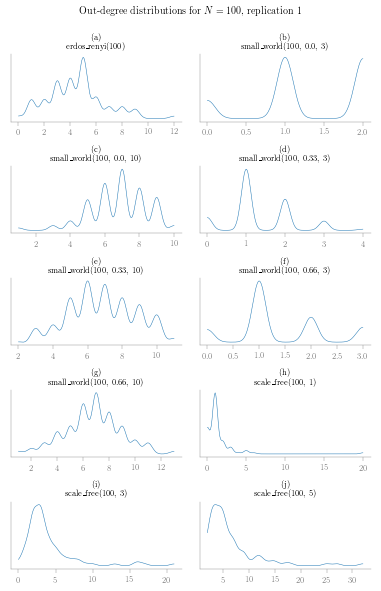

In [109]:
nrows, ncols = 5, 2
fig, axes = plt.subplots(nrows, ncols, figsize=set_size(textwidth, subplot=[nrows, ncols]))

for i, ax in enumerate(axes.ravel()):
    make_degree_kde(network_instances[i], ax)
    
fig.suptitle(f'Out-degree distributions for $N = 100$, replication 1', size=10);
fig.tight_layout()
fig.subplots_adjust(top=0.90)

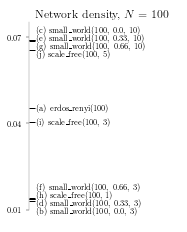

In [170]:
nrows, ncols = 1, 1
fig, ax = plt.subplots(nrows, ncols, figsize=set_size(textwidth, subplot=[nrows, ncols]))
fig.set_figwidth(fig.get_figwidth()/2)

densities = []
linelabels = []

for i, G in enumerate(network_instances):
    densities.append(nx.density(G))
    ax.plot(0, densities[-1], marker=1, color='black')
    
    network_name = str(G).replace('N', '100').replace('_', '\_')
    linelabels.append(ax.annotate(f'({string.ascii_lowercase[i]}) {network_name}',
                                  (0.045, densities[-1]),
                                       fontsize=8, ha='left', va='center', annotation_clip=False, color='black'))

    
densities = np.array(densities)
    
ax.spines['bottom'].set_color('None')
ax.spines['left'].set_color('grey')

ax.tick_params(axis='x', colors='None')
ax.set_xlim((0, 1));
ax.set_ylim((0.01, 0.075));
ax.set_yticks((0.01, 0.04, 0.07));
ax1.spines['left'].set_bounds(densities.min(), densities.max())

ax.set_title('Network density, $N = 100$')
fig.tight_layout()

fix_vertical_text_placement(linelabels, fig, ax, 0.08)


In [171]:
fig.savefig('../images/network_density_N_100.pdf', format='pdf', bbox_inches='tight')